# Complex Bayesian Network notebook

#### Import dependencies

In [57]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [58]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

## Data import and cleaning

#### Import BigPerf data

In [59]:
# Import data
df = pd.read_csv("Data\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [60]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [61]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [62]:
HBW_LABELS = ['1. Less than: 2.95 Mbps', '2. Between: 2.95 Mbps and 5.9 Mbps', '3. Between: 5.9 Mbps and 8.86 Mbps', '4. Greater than: 8.86 Mbps']
HTT_LABELS = ['1. Less than: 88.76 ms', '2. Between: 88.76 ms and 177.52 ms', '3. Between: 177.52 ms and 266.27 ms', '4. Greater than: 266.27 ms']
MMIPS_LABELS = ['1. Less than: 726605.75', '2. Between: 726605.75 and 800922.5', '3. Between: 800922.5 and 875239.25', '4. Greater than: 875239.25']
MET_LABELS = ['1. Less than: 943.85 ms', '2. Between: 943.85 ms and 1122.21 ms', '3. Between: 1122.21 ms and 1300.57 ms', '4. Greater than: 1300.57 ms']
MBW_LABELS = ['1. Less than: 8.62 Mbps', '2. Between: 8.62 Mbps and 15.75 Mbps', '3. Between: 15.75 Mbps and 22.87 Mbps', '4. Greater than: 22.87 Mbps']
MTT_LABELS = ['1. Less than: 14.5 ms', '2. Between: 14.5 ms and 26.5 ms', '3. Between: 26.5 ms and 38.51 ms', '4. Greater than: 38.51 ms']
RMIPS_LABELS = ['1. Less than: 253476', '2. Between: 253476 and 356952', '3. Between: 356952 and 460428', '4. Greater than: 460428']
RET_LABELS = ['1. Less than: 210 ms', '2. Between: 210 ms and 300 ms', '3. Between: 300 ms and 390.0 ms', '4. Greater than: 390.0 ms']
RBW_LABELS = ['1. Less than: 40.35 Mbps', '2. Between: 40.35 Mbps and 76.89 Mbps', '3. Between: 76.89 Mbps and 113.45 Mbps', '4. Greater than: 113.45 Mbps']
RTT_LABELS = ['1. Less than: 67.28 ms', '2. Between: 67.28 ms and 128.23 ms', '3. Between: 128.23 ms and 189.18 ms', '4. Greater than: 189.18 ms']
BBW_LABELS = ['1. Less than: 12.5 Mbps', '2. Between: 12.5 Mbps and 25 Mbps', '3. Between: 25 Mbps and 37 Mbps', '4. Greater than: 37 Mbps']
BTT_LABELS = ['1. Less than: 67.5 ms', '2. Between: 67.5 ms and 135 ms', '3. Between: 135 ms and 202.52 ms', '4. Greater than: 202.52 ms']
TT_LABELS = ['1. Less than: 1471.78 ms', '2. 1471.78 to 1935.93 ms', '3. 1935.93 to 2400.07 ms', '4. Greater than: 2400.07 ms']

In [63]:
def make_discrete(df):

    discrete_df = pd.DataFrame()

    discrete_df['HBW'] = pd.cut(df['HBW'], bins=4, labels=HBW_LABELS, ordered=True, precision=2)
    discrete_df['HTT'] = pd.cut(df['HTT'], bins=4, labels=HTT_LABELS, ordered=True, precision=2)
    discrete_df['MMIPS'] = pd.cut(df['MMIPS'], bins=4, labels=MMIPS_LABELS, ordered=True, precision=2)
    discrete_df['MET'] = pd.cut(df['MET'], bins=4, labels=MET_LABELS, ordered=True, precision=2)
    discrete_df['MBW'] = pd.cut(df['MBW'], bins=4, labels=MBW_LABELS, ordered=True, precision=2)
    discrete_df['MTT'] = pd.cut(df['MTT'], bins=4, labels=MTT_LABELS, ordered=True, precision=2)
    discrete_df['RMIPS'] = pd.cut(df['RMIPS'], bins=4, labels=RMIPS_LABELS, ordered=True, precision=2)
    discrete_df['RET'] = pd.cut(df['RET'], bins=4, labels=RET_LABELS, ordered=True, precision=2)
    discrete_df['RBW'] = pd.cut(df['RBW'], bins=4, labels=RBW_LABELS, ordered=True, precision=2)
    discrete_df['RTT'] = pd.cut(df['RTT'], bins=4, labels=RTT_LABELS, ordered=True, precision=2)
    discrete_df['BBW'] = pd.cut(df['BBW'], bins=4, labels=BBW_LABELS, ordered=True, precision=2)
    discrete_df['BTT'] = pd.cut(df['BTT'], bins=4, labels=BTT_LABELS, ordered=True, precision=2)
    discrete_df['TT'] = pd.cut(df['TT'], bins=4, labels=TT_LABELS, ordered=True, precision=2)

    discrete_df = discrete_df.astype('object')

    return discrete_df

#### Discretise data into catagories

In [64]:
cat_df = make_discrete(df)

cat_df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,4. Greater than: 22.87 Mbps,1. Less than: 14.5 ms,2. Between: 253476 and 356952,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,1. Less than: 67.5 ms,2. 1471.78 to 1935.93 ms
1,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,4. Greater than: 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,2. Between: 40.35 Mbps and 76.89 Mbps,1. Less than: 67.28 ms,4. Greater than: 37 Mbps,1. Less than: 67.5 ms,1. Less than: 1471.78 ms
2,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
3,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,1. Less than: 1471.78 ms
4,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
5,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,1. Less than: 40.35 Mbps,3. Between: 128.23 ms and 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,1. Less than: 1471.78 ms
6,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,4. Greater than: 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
7,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,4. Greater than: 113.45 Mbps,1. Less than: 67.28 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,1. Less than: 1471.78 ms
8,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,3. Between: 356952 and 460428,4. Greater than: 390.0 ms,1. Less than: 40.35 Mbps,4. Greater than: 189.18 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,2. 1471.78 to 1935.93 ms
9,4. Greater than: 8.86 Mbps,1. Less than: 88.76 ms,1. Less than: 726605.75,1. Less than: 943.85 ms,3. Between: 15.75 Mbps and 22.87 Mbps,1. Less than: 14.5 ms,1. Less than: 253476,1. Less than: 210 ms,4. Greater than: 113.45 Mbps,1. Less than: 67.28 ms,1. Less than: 12.5 Mbps,4. Greater than: 202.52 ms,1. Less than: 1471.78 ms


In [65]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [66]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.estimators.CITests import chi_square, cressie_read, freeman_tuckey, g_sq, independence_match, log_likelihood
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

In [67]:
pc = PC(data=training_data)
model = pc.estimate(variant='stable', ci_test=chi_square, return_type='dag', significance_level=0.25)

  0%|          | 0/5 [00:00<?, ?it/s]

In [68]:
bayes_model = BayesianNetwork(model)

#bayes_model.add_edge('MBW', 'MTT')

In [69]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

bayes_model.cpds = []

bayes_model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=False)

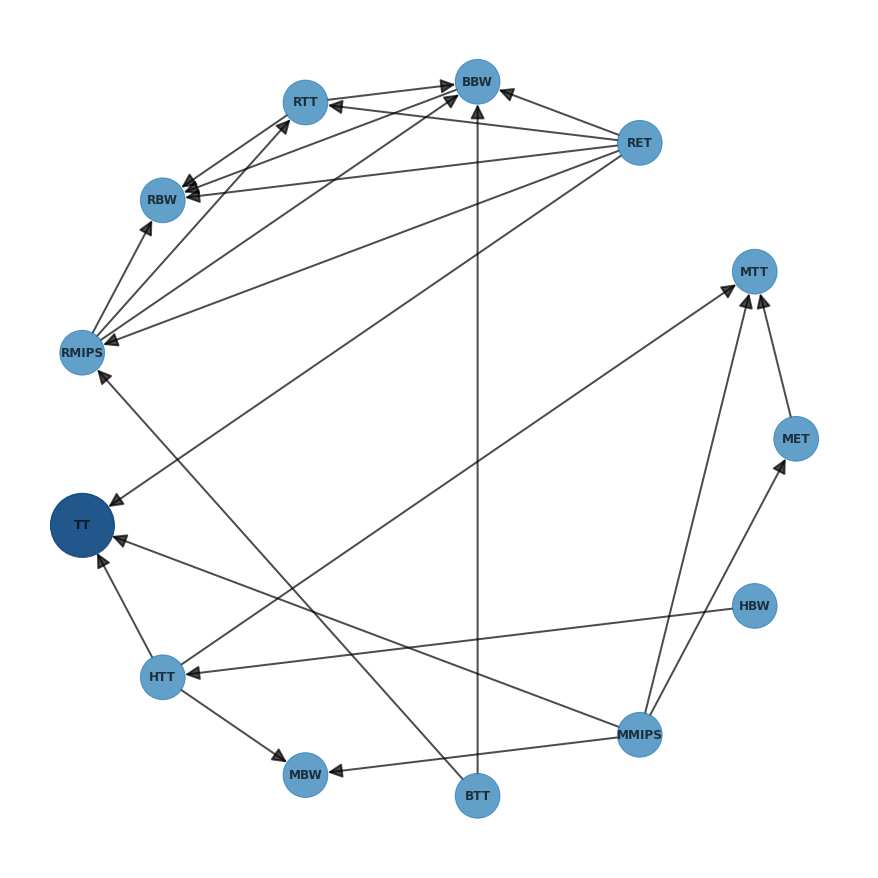

In [70]:
plt.figure(3,figsize=(12,12)) 
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.circular_layout(G)

nx.draw(G,
                pos=pos,
                with_labels=True,
                node_size=[2000,2000,2000,2000,2000,2000,2000,4000,2000,2000,2000,2000,2000],
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)  # Draw the original graph

tt_g = G.subgraph(nodes=['TT'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')
plt.show()

In [71]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

accuracy_dict = {}

for column in testing_data:
    predict_data = testing_data.copy()

    predict_data.drop(column, axis=1, inplace=True)

    
    
    y_pred = bayes_model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)
    

    print(f'{column} Accuracy score: {accuracy}')


    accuracy_dict[column] = accuracy

  0%|          | 0/150 [00:00<?, ?it/s]

HBW Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/152 [00:00<?, ?it/s]

HTT Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MMIPS Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/138 [00:00<?, ?it/s]

MBW Accuracy score: 0.8267716535433071


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/101 [00:00<?, ?it/s]

MTT Accuracy score: 0.5492125984251969


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/134 [00:00<?, ?it/s]

RMIPS Accuracy score: 0.8917322834645669


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/141 [00:00<?, ?it/s]

RTT Accuracy score: 0.8996062992125984


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BTT Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/137 [00:00<?, ?it/s]

TT Accuracy score: 0.8051181102362205


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


In [76]:
sum = 0
for v in accuracy_dict.values():
    sum += v

accuracy_dict['Average'] = sum / len(accuracy_dict.keys())

In [77]:
f1 = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=bayes_model, data=testing_data)
ss = structure_score(model=bayes_model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.782608695652174
Accuracy score: 0.8076923076923077
Precision score: 0.6428571428571429
Recall score: 1.0
Log-likilihood score: -3105.317366812069
Strcture score: -3376.9733968397077


In [81]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score, accuracy_dict):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    conv_dict = {}
    for k, v in accuracy_dict.items():
        conv_dict[k] = v*100
    
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score,
    'HBW prediction accuracy': conv_dict['HBW'], 'HTT prediction accuracy': conv_dict['HTT'], 'MMIPS prediction accuracy': conv_dict['MMIPS'], 'MET prediction accuracy': conv_dict['MET'],
    'MBW prediction accuracy': conv_dict['MBW'], 'MTT prediction accuracy': conv_dict['MTT'], 'RMIPS prediction accuracy': conv_dict['RMIPS'], 'RET prediction accuracy': conv_dict['RET'],
    'RBW prediction accuracy': conv_dict['RBW'], 'RTT prediction accuracy': conv_dict['RTT'], 'BBW prediction accuracy': conv_dict['BBW'], 'BTT prediction accuracy': conv_dict['BTT'],
    'TT prediction accuracy': conv_dict['TT'], 'Average prediction accuracy': conv_dict['Average']}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [82]:
model_name = 'Constraint-based CBN'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss, accuracy_dict=accuracy_dict)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_17508/3313813481.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [83]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of MET:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 

CPT of MTT:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 

CPT of RET:
+--------------------------------+----------+
| RET(1. Less than: 210 ms)      | 0.503927 |
+--------------------------------+----------+
| RET(4. Greater than: 390.0 ms) | 0.496073 |
+--------------------------------+----------+ 

CPT of BBW:
+-------------------------------+-----+---------------------------------+
| BTT                           | ... | BTT(4. Greater than: 202.52 ms) |
+-------------------------------+-----+---------------------------------+
| RET                           | ... | RET(4. Greater than: 390.0 ms)  |
+-------------------------------+-----+---------------------------------+
| RMIPS                         | ... | RMIPS(4. Greater than: 460428)  |
+-------------------------------+-----+------